# <center/> Multilayer Perceptrons </center>

In this lab we'll discuss multilayer perceptrons (the simplest type of neural network) and how to train them. By the end of the lab you should be able to:
- Describe what a multi-layer perceptron (MLP) is
- Describe how to train an MLP
- Implement an MLP yourself

## 1 Context

As we have done the rest of quarter, consider predicting an output $y$ from an input $x$. For this we may use a model $\hat y=f(x; \theta)$ for some function $f$ and parameters $\theta$. For example, we could have $f(x; W,b) = W^Tx + b$ as in linear regression or $f(x) = <\phi(x), f>_\mathcal{H}$ as in kernel ridge regression. How do we find appropriate parameter values? And how do we choose the function $f$?

Assume we have training data $(x_i,y_i)_{i=1}^n$. Given a loss function $\ell$, we would ideally like to fit the model by minimizing the expected loss
$$\mathbb{E}_{(X,Y)\sim \mathbb{P}} \ell(y, f(x; \theta)),$$
assuming that the data is distributed iid according to some distribution $\mathbb{P}$. As we generally don't know $\mathbb{P}$, we instead minimize the loss on the training set:
$$\frac{1}{n}\sum_{i=1}^n \ell(y_i, f(x_i; \theta)) + \Omega(\theta),$$
typically with a regularization term $\Omega$ added.

- Example 1: Linear regression  
Output: $\hat y = f(x) = W^Tx + b$  
Loss: $\ell(y, \hat y) = (y-\hat y)^2$
- Example 2: Logistic regression  
Output: $\hat y = f(x) = s(W^Tx + b)$, where $s(z) = \frac{\exp(z)}{1+\exp(z)}$  
Loss: $\ell(y, \hat y) = -y\log(\hat y) - (1-y)\log(1-\hat y)$ (when the labels are 0/1)
- Example 3: Kernel SVM with squared hinge loss  
Output: $\hat y = f(x) = <\phi(x), f>_\mathcal{H}$  
Loss: $\ell(y, \hat y) = \max(0, 1-y\hat y)^2$

When it comes to choosing the functional form $f$ there is a bias-variance tradeoff. Simple models such as linear models have high bias and low variance. Linear models work well if the decision boundary is close to linear and can fail miserably otherwise (see the last lab). On the other hand, complex models with many parameters have low bias and high variance. They can fit nonlinear decision boundaries, but can be prone to overfitting.

In the last lab we explored kernel SVMs to perform classification tasks and saw that they transform features to yield nonlinear decision boundaries. In this lab we examine multilayer perceptrons, which provide an alternative means of transforming features to obtain nonlinear decision boundaries. 

## 2 What is a multi-layer perceptron?

Multilayer perceptrons set $f$ to be a composition of functions:
$$f(x) = f_{L}(f_{L-1}(f_{L-2}(\cdots (f_1(x))))),$$
where each $f_j$ is of the form $f_j=g_j(W_j^Tx+b_j)$ and $g_j$ is a nonlinear function. $f_1,\dots, f_{L-1}$ are called the hidden layers while $f_L$ is called the output layer. The exact specifications are context-specific, but you can think of $f_1,\dots, f_{L-1}$ as generating a new representation of the input and of the final layer as being part of a classifier on top. 

There are many questions you might ask:

**How do you choose how many $f_j$'s (layers) there are? What about the dimension of each layer?**  
That is problem-specific and people typically set these parameters using background knowledge and experimentation. 

**How do you choose the nonlinear functions $g_j$ at the hidden layers?**  
People have suggested a number of different functions, including tanh, sigmoid, and $\max(x,0)$ (called the rectified linear unit or ReLU). These days ReLUs are most popular. People typically use the same type of nonlinearity for each hidden layer.

** How do you choose the nonlinear function $g_L$ at the output layer? **  
This depends on the type of problem you are trying to solve. For regression problems you would typically use the identity function, whereas for multiclass classification you would use the softmax function.

** How do you choose a loss function? **  
Similarly to the last question, this is problem-specific. People mostly use the negative log-likelihood.

** How do you train such a model? **  
The typical training method is stochastic gradient descent. There is a method called backpropagation that allows you to compute the derivatives efficiently. Note that a model like this is very non-convex and is not robust to the choice of initialization.

** How do you initialize the weights for the training? **   
Typically people use small randomly drawn values for the weights and zero for the biases. A common recommendation is for each layer $j$ to use values drawn iid from $N(0, 2/d_j)$, where $d_j$ is the dimension of the inputs to layer $j$. What you don't want to do is initialize the weights to zero. 

** Why would we use a neural network as opposed to other methods, such as kernel-based methods? **  
Traditionally neural networks have outperformed other methods, including kernel-based methods. 

## 3 Scikit-learn example
In this section we'll see how to use scikit-learn to fit an MLP. Recall the data from last week:

Number of training examples: 60
Number of test examples: 40


[]

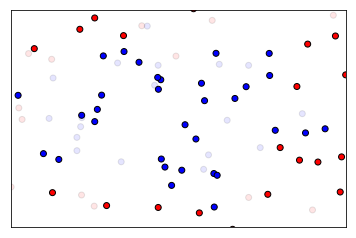

In [28]:
%matplotlib inline
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = sklearn.datasets.make_circles(noise=0.2, factor=0.5, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('Number of training examples:', X_train.shape[0])
print('Number of test examples:', X_test.shape[0])

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
# Plot the training points
ax = plt.subplot()
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
           edgecolors='k')
# and testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.1,
           edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())

In [29]:
def plot_results(probs, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, xx=xx, yy=yy):
    Zs = np.c_[xx.ravel(), yy.ravel()]

    # Put the result into a color plot
    probs = probs.reshape(xx.shape)
    ax = plt.subplot()
    ax.contourf(xx, yy, probs, cmap=cm, alpha=.8)

    # Plot also the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
               edgecolors='k', alpha=0.2)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    plt.show()
    

This time let's fit an MLP with the one hidden layer. This MLP will use the ReLU nonlinearity at the first layer and the dimension of the representation at the hidden layer will be five (i.e., it will have five hidden units). The second layer (the output layer) will use the sigmoid function to produce output probabilities. In summary, the neural net will be of the form 

$$\hat y = f(x) = s(W_2^T \max(W_1^Tx+b_1, 0) + b_2)$$ 
where $$s(z) = \frac{\exp(z)}{1+\exp(z)}.$$

The loss function will be the negative log-likelihood. Recall from lab 3 that this is given by
$$ \ell(y, \hat y) = -y\log(\hat y) - (1-y)\log(1-\hat y).$$

** Exercise 1 ** Given that the inputs have dimension 2 and the hidden layer has dimension 5, what are the dimensions of $W_1$, $b_1$, $W_2$, and $b_2$?

** Exercise 2 ** Using scikit-learn's MLPClassifier, fit the above model. Call the instantiated classifier `mlp`, use lbfgs as the optimizer (as it is a small-scale problem) and set `alpha=2`. 

In [30]:
from sklearn.neural_network import MLPClassifier

hidden_layer_sizes = (5)
mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, solver='lbfgs', alpha=2, random_state=0)
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=2, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=5, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

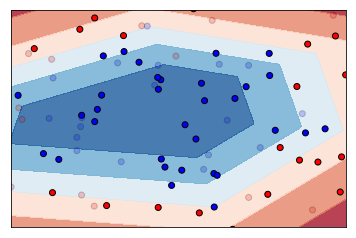

In [31]:
Zs = np.c_[xx.ravel(), yy.ravel()]
probs = mlp.predict_proba(Zs)
plot_results(probs[:, 1])

** Exercise 3* ** Perform cross-validation to choose `alpha`. Recall that you can do this using `GridSearchCV`.

## 4 Training an MLP

Traditionally MLPs have been trained via stochastic backpropagation methods. In this section we'll see how to train the network from above with the stochastic subgradient method.

First recall the chain rule. Let $z = u(v(x))$ for a vector $x\in\mathbb{R}^{d_0}$, a function $v:\mathbb{R}^{d_0}\to\mathbb{R}^{d_1}$, and a function $u:\mathbb{R}^{d_1}\to\mathbb{R}$. Then the derivative of $z$ with respect to the $i$th element of $x$ is given by
$$ \frac{\partial z}{\partial x_i} = \sum_{j=1}^{d_1} \frac{\partial z}{\partial v_j}\frac{\partial v_j}{\partial x_i}$$

** Exercise 4 ** Suppose $x=(x_1,x_2)\in\mathbb{R}^2$, $v(x_1,x_2) = [x_2^2, x_1^2]$, and $z=u(v_1, v_2) = v_1+v_2$. Compute $\frac{\partial z}{\partial x_1}$ and $\frac{\partial z}{\partial x_2}$.

Recall that our neural net outputs
$$\hat y = f(x) = s(W_2^T \max(W_1^Tx+b_1, 0) + b_2)$$ 
where $$s(z) = \frac{\exp(z)}{1+\exp(z)}$$ is the sigmoid function.

** Exercise 5 ** Compute $\frac{\partial f}{\partial W_2}$ and $\frac{\partial f}{\partial b_2}$.  

** Exercise 6 ** Compute the subdifferentials $\partial_{W_1} f$ and $\partial_{b_1}f$.

Recall that the loss function we're using is given by
$$ \ell(y, \hat y) = -y\log(\hat y) - (1-y)\log(1-\hat y).$$
** Exercise 7 ** Compute $\frac{\partial \ell(y, f(x))}{\partial W_2}$ and $\frac{\partial \ell(y, f(x))}{\partial b_2}$, $\partial_{W_1} \ell(y, f(x))$, and $\partial_{b_1} \ell(y, f(x))$

## 5 Do-it-yourself MLP

Next we'll code the MLP from above ourselves to perform the previous binary classification task. 

The code below is adapted from here: https://github.com/m2dsupsdlclass/lectures-labs/blob/master/labs/02_backprop/Backpropagation_numpy.ipynb

** Exercise 7 ** Fill in the code below to compute the ReLU activation and a subgradient.

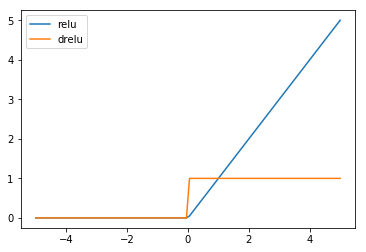

In [32]:
def relu(X):
    # TODO
    return np.maximum(X, 0)


def drelu(X):
    # TODO
    return 1*(X > 0)


x = np.linspace(-5, 5, 100)
plt.plot(x, relu(x), label='relu')
plt.plot(x, drelu(x), label='drelu')
plt.legend(loc='best');

** Exercise 8 ** Fill in the code below with the sigmoid function.

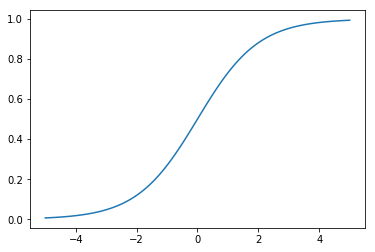

In [38]:
def sigmoid(X):
    # TODO
    return np.exp(X)/(1+np.exp(X))

plt.plot(x, sigmoid(x))

The next set of exercises all refer to the code in the `NeuralNet` class below.

** Exercise 9 ** Complete the `__init__` method to initialize the biases to zero and the weights to be drawn from a normal distribution with mean zero and standard deviation $\sqrt{2/d_j}$, where $d_j$ is the dimension of the features being input into layer $j$.

** Exercise 10 ** Complete the `forward()` method to return the output of the neural network. 

** Exercise 11 ** Complete the `forward_keep_activations` method. Here $h = \max(W_1^Tx+b_1, 0)$, $y=\text{softmax}(W^T_2h+b_2)$, and $z_h=W_1^Tx+b_1$.

** Exercise 12 ** Complete the `loss` method. 

** Exercise 13 ** Complete the `predict` method to predict whether the label of an input X should be 1 or 0.

** Exercise 14 ** Complete the `grad_loss` method with the derivatives of the loss with respect to $W_1, b_1, W_2$, and $b_2$.

** Exercise 15 ** Complete the `train` method. This should run one step of the stochastic subgradient method (which is like SGD, except using subgradients) with the specified learning rate.

In [39]:
class NeuralNet():
    """MLP with 1 hidden layer with a ReLU activation"""

    def __init__(self, input_size, hidden_size):
        # TODO
        self.W_1 = np.random.normal(size=(input_size, hidden_size), loc=0, scale=np.sqrt(2 / input_size))
        self.b_1 = np.zeros(hidden_size)
        self.W_2 = np.random.normal(size=(hidden_size), loc=0, scale=np.sqrt(2 / hidden_size))
        self.b_2 = 0
        self.output_size = 1

    def forward(self, X):
        # TODO
        if len(X.shape) == 1:
            h = relu(np.dot(X, self.W_1) + self.b_1)
            return sigmoid(np.dot(self.W_2, h) + self.b_2)
        else:
            h = relu(np.dot(X, self.W_1) + self.b_1)
            return sigmoid(np.dot(h, self.W_2) + self.b_2)

    def forward_keep_activations(self, X):
        # TODO
        z_h = np.dot(X, self.W_1) + self.b_1
        h = relu(z_h)
        y = sigmoid(np.dot(h, self.W_2) + self.b_2)

        return y, h, z_h

    def loss(self, X, y):
        # TODO
        yhat = self.forward(X)
        return np.mean(-y * np.log(yhat) - (1 - y) * np.log(1 - yhat))

    def grad_loss(self, x, y_true):
        # TODO
        y, h, z_h = self.forward_keep_activations(x)
        grad_z_o = y - y_true
        grad_w_2 = grad_z_o*h
        grad_b_2 = grad_z_o
        grad_h = grad_z_o*self.W_2
        grad_z_h = grad_h * drelu(z_h)
        grad_w_1 = np.outer(x, grad_z_h)
        grad_b_1 = grad_z_h

        return {"W_1": grad_w_1, "b_1": grad_b_1, "W_2": grad_w_2, "b_2": grad_b_2}

    def train(self, x, y, learning_rate):
        # TODO
        grads = self.grad_loss(x, y)
        self.W_1 -= learning_rate * grads['W_1']
        self.b_1 -= learning_rate * grads['b_1']
        self.W_2 -= learning_rate * grads['W_2']
        self.b_2 -= learning_rate * grads['b_2']

    def predict(self, X):
        return (self.forward(X) > 0.5)

    def accuracy(self, X, y):
        y_preds = self.predict(X)
        return np.mean(y_preds == y)

In [40]:
n_hidden = 10
np.random.seed(0)
n_features = np.size(X_train, 1)
model = NeuralNet(n_features, n_hidden)

In [41]:
model.loss(X_train, y_train)

0.78546957506475301

In [42]:
model.accuracy(X_train, y_train)

0.56666666666666665

In [43]:
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(100):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.01)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Random init: train loss: 0.78547, train acc: 0.567, test acc: 0.550
Epoch #1, train loss: 0.71454, train acc: 0.533, test acc: 0.525
Epoch #2, train loss: 0.69249, train acc: 0.583, test acc: 0.550
Epoch #3, train loss: 0.67558, train acc: 0.583, test acc: 0.525
Epoch #4, train loss: 0.66108, train acc: 0.567, test acc: 0.550
Epoch #5, train loss: 0.64817, train acc: 0.600, test acc: 0.550
Epoch #6, train loss: 0.63641, train acc: 0.633, test acc: 0.575
Epoch #7, train loss: 0.62550, train acc: 0.683, test acc: 0.600
Epoch #8, train loss: 0.61493, train acc: 0.717, test acc: 0.700
Epoch #9, train loss: 0.60657, train acc: 0.733, test acc: 0.725
Epoch #10, train loss: 0.59886, train acc: 0.733, test acc: 0.750
Epoch #11, train loss: 0.59114, train acc: 0.750, test acc: 0.750
Epoch #12, train loss: 0.58364, train acc: 0.750, test acc: 0.750
Epoch #13, train loss: 0.57643, train acc: 0.750, test acc: 0.775
Epoch #14, train loss: 0.56931, train acc: 0.750, test acc: 0.775
Epoch #15, train 

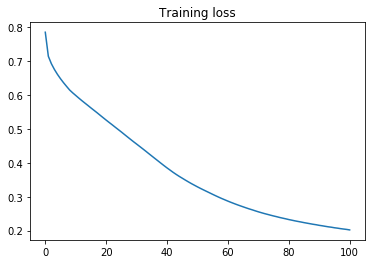

In [44]:
plt.plot(losses)
plt.title("Training loss");

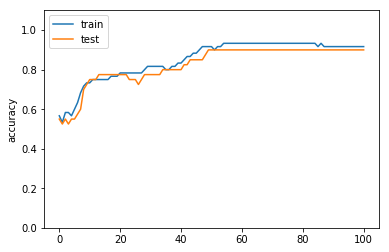

In [45]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best');

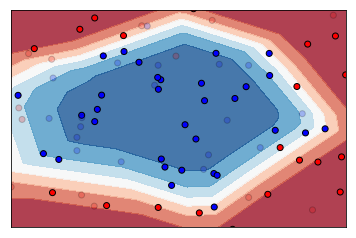

In [46]:
probs = model.forward(Zs)
plot_results(probs)

** Exercise 16* ** Add regularization to the network. Then compare to the results from scikit-learn. 